un Recommendeur de joueurs similaires. Le but est de trouver des joueurs qui ont un style ou des performances proches d’un joueur donné


PCA : pour réduire la dimensionnalité des données.

KMeans : pour grouper les joueurs selon leurs styles.

Cosine similarity : pour mesurer leur "distance" réelle dans l'espace de stats.

In [2]:
import pandas as pd

# Load your cleaned dataset
df = pd.read_excel("encoded_data.xlsx")

# Select relevant numeric features (exclude name, team, league, etc.)
features = ['age', 'overall_rating', 'p_goals', 'assists', 'expected_goals_(xg)',
            'successful_dribbles', 'tackles', 'accurate_passes_%']

player_info = df[['name', 'team', 'league']]  # For display
X = df[features].copy()


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)  # Reduce to 5D for clustering
X_pca = pca.fit_transform(X_scaled)


In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Add cluster labels back to the original dataframe
df['cluster'] = clusters


In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_similar_players(player_name, top_n=5):
    idx = df[df['name'] == player_name].index[0]
    player_vector = X_scaled[idx].reshape(1, -1)
    
    similarities = cosine_similarity(player_vector, X_scaled).flatten()
    similar_indices = np.argsort(similarities)[::-1][1:top_n+1]

    return df.loc[similar_indices, ['name', 'team', 'league', 'cluster']], similarities[similar_indices]


In [15]:
# Replace with a real player name in your dataset
similar_players, scores = find_similar_players("kylian_mbappe", top_n=5)
print(similar_players)
print("Similarity Scores:", scores)


                 name                    team          league  cluster
2174       moise_kean              fiorentina         serie_a        1
489    julian_alvarez         atletico_madrid         la_liga        1
1070  ousmane_dembele     paris_saint-germain         ligue_1        1
1071  mason_greenwood  olympique_de_marseille         ligue_1        1
1614   alexander_isak        newcastle_united  premier_league        1
Similarity Scores: [0.9746048  0.97438353 0.95760433 0.95719401 0.95667255]


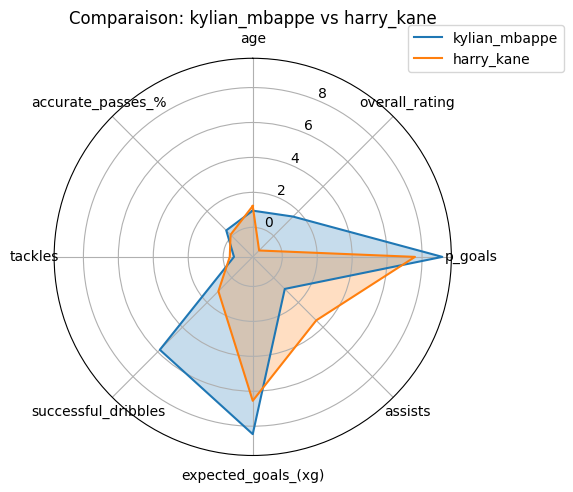

In [14]:
from matplotlib import pyplot as plt


def radar_plot(player1_name, player2_name):
    # Indices
    idx1 = df[df['name'] == player1_name].index[0]
    idx2 = df[df['name'] == player2_name].index[0]

    # Normaliser les valeurs
    stats1 = X_scaled[idx1]
    stats2 = X_scaled[idx2]

    # Créer un radar chart
    labels = features
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    stats1 = np.concatenate((stats1, [stats1[0]]))
    stats2 = np.concatenate((stats2, [stats2[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    ax.plot(angles, stats1, label=player1_name)
    ax.fill(angles, stats1, alpha=0.25)

    ax.plot(angles, stats2, label=player2_name)
    ax.fill(angles, stats2, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(f"Comparaison: {player1_name} vs {player2_name}")
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

radar_plot("kylian_mbappe", "harry_kane")  # Replace with real player names in your dataset


In [18]:
import joblib

joblib.dump(kmeans, "models/kmeans_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(pca, "models/pca.pkl")
df.to_csv("data/clustered_players.csv", index=False)